In [10]:
%run Text_Preprocessing.ipynb

Documentation:
1. Converted class label to categorical
2. Supplied (original) vectorisers + TF-IDF vectorizer
3. Added preprocessing (punctuation removal, casefolding, stop-words removal (including words to short), lemmatization) steps to the text features
4. Encoded the simple string features ('Authors', 'Publisher', 'Language')
5. Dimensionality reduction with TruncatedSVD
6. Bigrams instead of words
7. Feature selection with SelectKBest
8. Standardization of 'pageNumbers' 
9. Instead of 8: Take the log of the standardized 'pageNumbers' using MinMaxScaler

Yet to try:
* Discretisation of PageNumbers

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy
from scipy import sparse
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load datasets
original_train_df = pd.read_csv(r"book_rating_train.csv", index_col = False, delimiter = ',', header=0)
original_test_df = pd.read_csv(r"book_rating_test.csv", index_col = False, delimiter = ',', header=0)
print("Training set size:", len(original_train_df))
print("Test set size:", len(original_test_df))

Training set size: 23063
Test set size: 5766


In [4]:
# Make a copy of the original datasets
train_df = original_train_df.copy()
test_df = original_test_df.copy()

## Preprocess String features: Language, Authors, and Publisher

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
STRING_FEATURES = ['Authors', 'Publisher', 'Language']

In [7]:
for feature in STRING_FEATURES:
    print(f"There are {original_train_df[feature].nunique()} unique '{feature}' values.")
    print(f"There are {original_train_df[feature].isna().sum()} missing '{feature}' values.")

# Too many missing values in 'Language'. Let's drop it.

There are 16301 unique 'Authors' values.
There are 0 missing 'Authors' values.
There are 4247 unique 'Publisher' values.
There are 148 missing 'Publisher' values.
There are 18 unique 'Language' values.
There are 17202 missing 'Language' values.


In [8]:
def preprocess_string_feature(df, feature, ohe=None):
    # first preprocess the strings
    df[feature] = df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    
    if ohe is None:
        ohe = OneHotEncoder(handle_unknown='ignore')
        ohe.fit(df[[feature]])
    
    transformed_col = ohe.transform(df[[feature]])  # a sparse matrix
    transformed_df = pd.DataFrame.sparse.from_spmatrix(transformed_col).set_axis(ohe.categories_[0], axis=1, inplace=False)
    
    return transformed_df, ohe

In [11]:
train_df_author, ohe_author = preprocess_string_feature(train_df, 'Authors')
train_df_publisher, ohe_publisher = preprocess_string_feature(train_df, 'Publisher')
train_df = pd.concat([train_df, train_df_author, train_df_publisher], axis=1)
train_df = train_df.drop(STRING_FEATURES, axis=1)  # drop the original features
train_df

,Name,PublishYear,PublishMonth,PublishDay,pagesNumber,Description,rating_label,,aaron bank,aaron beck,...,zero three,zoland books,zonderkidz,zondervan,zondervan academic,zondervan publishing company,zone books,zsolnay,zubaan books penguin india,zzdap publishing
0,Best of Dr Jean: Reading & Writing,2005,6,1,48,Teachers will turn to this treasury of ideas a...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Here All Dwell Free,1991,10,1,364,Every human being lives a fairy tale -- an unc...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Boomer's Big Surprise,2005,3,31,32,<i>Boomer's Big Surprise</i> will have special...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"I'll Go and Do More: Annie Dodge Wauneka, Nava...",2004,9,1,293,<i>I'll Go and Do More</i> is the story of Ann...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Us,2005,7,7,352,"Since their days at Oxford, they've gone their...",3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,Black Coffee Blues,1997,8,1,120,"""If I lose the light of the sun, I will write ...",4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23059,America's Champion Swimmer: Gertrude Ederle,2005,6,1,32,"Trudy Ederle loved to swim, and she was determ...",4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23060,Crime and Custom in Savage Society,1989,2,15,132,Bronislaw Malinowski achieved international re...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23061,The Name and Nature of Poetry and Other Select...,1998,4,21,136,Lovers of Housman's poetry and admirers of his...,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
sorted(ohe_author.categories_[0])

['',
 'aaron bank',
 'aaron beck',
 'aaron hamburger',
 'aaron hass',
 'aaron kramer',
 'aaron latham',
 'aaron mccollough',
 'aaron reynolds',
 'aaron spencer fogleman',
 'aaron travis',
 'abba kovner',
 'abby mann',
 'abd rahman jabarti',
 'abdal hakim murad',
 'abdelwahab bouhdiba',
 'abdul janmohamed',
 'abdul kalam',
 'abdul sattar',
 'abdulaziz sachedina',
 'abigail tabby',
 'abraham eraly',
 'abraham kuyper',
 'abraham malherbe',
 'abraham schmitt',
 'abraham silberschatz',
 'abraham verghese',
 'abram hoffer',
 'abrams',
 'absjorn intonsus',
 'abu hamid ghazali',
 'abul abbas',
 'achim ger',
 'acton figueroa',
 'ada leverson',
 'adam beechen',
 'adam brandenburger',
 'adam copeland',
 'adam fairclough',
 'adam gallardo',
 'adam gamble',
 'adam hamilton',
 'adam haslett',
 'adam kahane',
 'adam kennedy',
 'adam lane',
 'adam mayers',
 'adam morgan',
 'adam phillips',
 'adam smith',
 'adam stemple',
 'adam white',
 'adams',
 'adams sitney',
 'addi booth',
 'addison terry',
 'adel

## Preprocess Numerical features: PublishDates and pagesNumber

### Data Visualisation

In [13]:
NUMERICAL_FEATURES = ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber']
X_train_numerical = train_df[NUMERICAL_FEATURES]
y_train = train_df['rating_label']

In [14]:
# Look at NMI of the numerical attributes
from sklearn.metrics.cluster import normalized_mutual_info_score

for feature in NUMERICAL_FEATURES:
    print(f"NMI for {feature} =", normalized_mutual_info_score(X_train_numerical[feature], y_train))

NMI for PublishYear = 0.005010413368619569
NMI for PublishMonth = 0.0007191125502055215
NMI for PublishDay = 0.0013529681241697595
NMI for pagesNumber = 0.01964529722439041


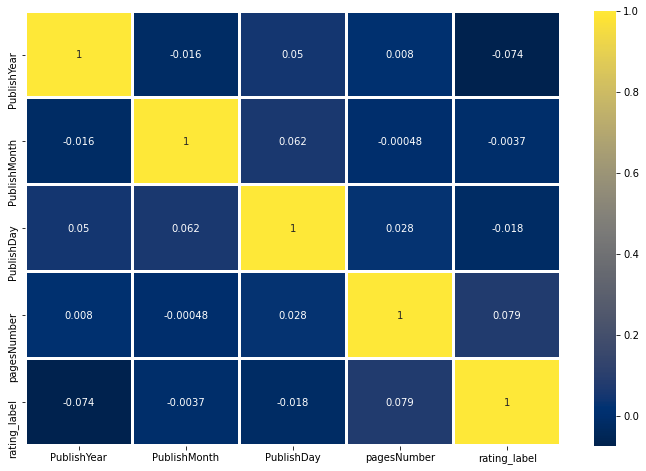

In [15]:
# Look at the correlation matrix of the numerical attributes
cor_matrix = train_df[NUMERICAL_FEATURES + ['rating_label']].corr()
round(cor_matrix, 2)
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix, cmap='cividis', annot=True, linewidths=2)
plt.show()

# Looks like there's little correlation between the Publish time and rating_label

In [16]:
def plot_vs_rating(df, feature):
    plt.scatter(df[feature], df['rating_label'])
    plt.xlabel(feature)
    plt.ylabel('rating')

In [ ]:
# Scatterplots for Publish year, month, and day vs. Rating
for feature in ['PublishYear', 'PublishMonth', 'PublishDay']: 
    plot_vs_rating(train_df, feature)
    
    # Look at the average rating for each value
    values, counts = np.unique(sorted(train_df[feature]), return_counts=True)
    avg = [sum(train_df.loc[train_df[feature] == values[i]]['rating_label']) / counts[i] for i in range(len(values))]
    plt.plot(values, avg, color = 'red')
    plt.show()

In [30]:
# PublishMonth and PublishDay don't seem so relevant, let's drop it
train_df = train_df.drop(['PublishMonth', 'PublishDay'], axis=1)

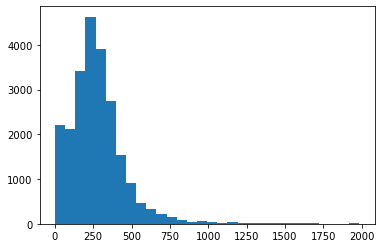

In [31]:
# Histogram for pages number < 2000
pageNum = train_df.loc[train_df['pagesNumber'] < 2000]['pagesNumber']
plt.hist(pageNum, bins = 30)
plt.show()

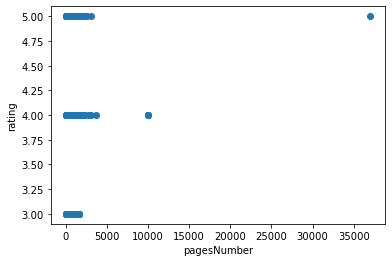

In [32]:
plot_vs_rating(train_df, 'pagesNumber')
plt.show()

In [33]:
# Try discretizing it
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, feature, discretizer=None, strategy='kmeans', n_bins=7):
    if discretizer is None:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        discretizer.fit(df[[feature]])
        
    transformed_df = df.copy()
    transformed_df[feature] = discretizer.transform(df[[feature]])
    
    return transformed_df, discretizer

In [34]:
DISCRETIZATION_STRATEGIES = ['kmeans', 'quantile', 'uniform']

def tune_discretization(X, y, feature, lower, upper):
    """
    Returns the combination of n (number of bins) and discretisation strategy 
    that gives the highest normalised mutual information between `X` and `y`.
    """
    
    max_nmi = 0
    best_n = 0
    best_strategy = None
    
    for n in range(lower, upper+1):
        for strategy in DISCRETIZATION_STRATEGIES:
            transformed_X, _ = discretize(X, feature, strategy=strategy, n_bins=n)
            nmi = normalized_mutual_info_score(transformed_X[feature], y)
            if nmi > max_nmi:
                max_nmi = nmi
                best_n = n
                best_strategy = strategy
    
    return max_nmi, best_n, best_strategy

In [35]:
max_nmi_pn, best_n_pn, best_strategy_pn = tune_discretization(X_train_numerical, y_train, 'pagesNumber', 2, 20)
print("The number of bins that gives the highest NMI with rating_label is", best_n_pn)
print("The highest NMI is:", max_nmi_pn)
print("The best strategy is:", best_strategy_pn)

The number of bins that gives the highest NMI with rating_label is 7
The highest NMI is: 0.013006785743756806
The best strategy is: kmeans


In [36]:
train_df, discretizer_pn = discretize(train_df, 'pagesNumber', strategy='kmeans', n_bins=7)
np.unique(train_df['pagesNumber'], return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([ 7578, 10024,  4422,   917,   118,     3,     1]))

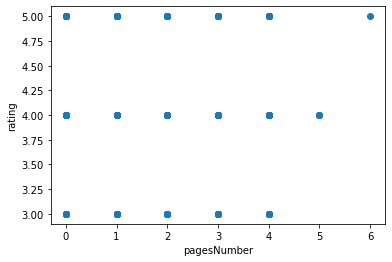

In [37]:
plot_vs_rating(train_df, 'pagesNumber')

In [38]:
# Try discretizing PublishYear as well 
max_nmi_py, best_n_py, best_strategy_py = tune_discretization(X_train_numerical, y_train, 'PublishYear', 2, 100)
print("The number of bins that gives the highest NMI with rating_label is", best_n_py)
print("The highest NMI is:", max_nmi_py)
print("The best strategy is:", best_strategy_py)

The number of bins that gives the highest NMI with rating_label is 15
The highest NMI is: 0.006425277331391137
The best strategy is: uniform


In [39]:
train_df, discretizer_py = discretize(train_df, 'PublishYear', strategy='uniform', n_bins=15)
np.unique(train_df['PublishYear'], return_counts=True)

(array([ 0.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 array([    1,     5,     4,     6,     8,    19,    59,   233,  1080,
         5058, 16219,   371]))

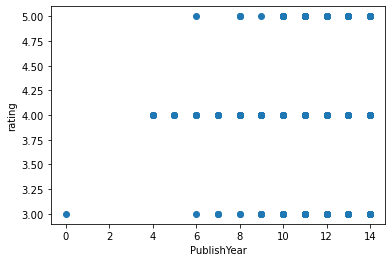

In [40]:
plot_vs_rating(train_df, 'PublishYear')

## Text Pre-processing

In [41]:
train_df_name, vectorizer_name = preprocess_text_feature(train_df, 'Name', ngram=2)  # can try ngram=1
train_df_desc, vectorizer_desc = preprocess_text_feature(train_df, 'Description', ngram=2)

In [42]:
sorted(vectorizer_name.vocabulary_)

['able team',
 'african american',
 'alexander great',
 'america first',
 'american culture',
 'american girl',
 'american history',
 'american indian',
 'american politics',
 'american revolution',
 'american woman',
 'ancient world',
 'anglo saxon',
 'archive vol',
 'around world',
 'art craft',
 'art therapy',
 'art war',
 'aunt dimity',
 'avant garde',
 'beginner guide',
 'berenstain bear',
 'best american',
 'best friend',
 'best kept',
 'best practice',
 'betty crocker',
 'bible commentary',
 'bible new',
 'bible niv',
 'bible study',
 'big book',
 'black beauty',
 'black lagoon',
 'black white',
 'black woman',
 'board book',
 'book bible',
 'book one',
 'brief history',
 'cam jansen',
 'cambridge companion',
 'catholic church',
 'changed world',
 'chapter book',
 'child book',
 'choose adventure',
 'christian faith',
 'city guide',
 'civil right',
 'civil war',
 'cold war',
 'collected story',
 'collected work',
 'common sense',
 'complete book',
 'complete guide',
 'complete i

In [43]:
sorted(vectorizer_desc.vocabulary_)

['across country',
 'affordable high',
 'african american',
 'age may',
 'along way',
 'also included',
 'also includes',
 'also provides',
 'american culture',
 'american history',
 'answer question',
 'antiquarian book',
 'anyone interested',
 'around world',
 'available part',
 'available purchase',
 'award winning',
 'behind scene',
 'believe work',
 'best book',
 'best friend',
 'best known',
 'best selling',
 'bestselling author',
 'black white',
 'book also',
 'book award',
 'book contains',
 'book cover',
 'book examines',
 'book explores',
 'book facsimile',
 'book feature',
 'book first',
 'book help',
 'book includes',
 'book offer',
 'book one',
 'book present',
 'book provides',
 'book review',
 'book show',
 'book take',
 'book tell',
 'book written',
 'book year',
 'brand new',
 'brings together',
 'case study',
 'change life',
 'child book',
 'civil right',
 'civil war',
 'classic work',
 'cold war',
 'color illustration',
 'color photograph',
 'com book',
 'comic book'

In [44]:
# Bind them together
train_df = pd.concat([train_df, train_df_name, train_df_desc], axis=1)
train_df = train_df.drop(['Name', 'Description'], axis=1)  # drop the original columns

## Convert rating_label to categorical class label

In [45]:
# Finally, convert rating_label to categorical class label
def preprocess_class_label(df):
    df['rating_label'] = df['rating_label'].astype('category')
    return df

In [46]:
train_df = preprocess_class_label(train_df)
# move rating_label to the last column
labels = train_df['rating_label']
train_df = pd.concat([train_df.drop(['rating_label'], axis=1), labels], axis=1) 
train_df

,PublishYear,pagesNumber,,aaron bank,aaron beck,aaron hamburger,aaron hass,aaron kramer,aaron latham,aaron mccollough,...,north america,paperback edition,book cover,book one,family life,civil right,step instruction,young girl,everything need,rating_label
0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
23059,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
23060,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
23061,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [47]:
# Check class distributions
class_labels, count = np.unique(train_df['rating_label'], return_counts=True)
for pair in zip(class_labels, count):
    print(f"Rating {pair[0]}: {pair[1]} instances")

Rating 3.0: 5864 instances
Rating 4.0: 16208 instances
Rating 5.0: 991 instances


# Preprocessing: Altogether

In [48]:
def preprocess_df(df, ohe_author=None, ohe_publisher=None, discretizer_pn=None, discretizer_py=None):
    # preprocess string features
    df_author, _ = preprocess_string_feature(df, 'Authors', ohe=ohe_author)
    df_publisher, _ = preprocess_string_feature(df, 'Publisher', ohe=ohe_publisher)
    
    # preprocess pagesNumber and PublishYear
    df, _ = discretize(df, 'pagesNumber', discretizer=discretizer_pn)
    df, _ = discretize(df, 'PublishYear', discretizer=discretizer_py)
    
    # preprocess text features
    df_name, _ = preprocess_text_feature(df, 'Name', vectorizer=vectorizer_name)
    df_desc, _ = preprocess_text_feature(df, 'Description', vectorizer=vectorizer_desc)
    
    # finally, discard the original features and some unwanted features
    df = pd.concat([df, df_author, df_publisher, df_name, df_desc], axis=1)
    df = df.drop(['Authors', 'Publisher', 'Name', 'Description', 'PublishMonth', 'PublishDay', 'Language'], axis=1)
    
    return df

In [49]:
test_df = preprocess_df(test_df, ohe_author, ohe_publisher, discretizer_pn, discretizer_py)
test_df

,PublishYear,pagesNumber,,aaron bank,aaron beck,aaron hamburger,aaron hass,aaron kramer,aaron latham,aaron mccollough,...,love affair,north america,paperback edition,book cover,book one,family life,civil right,step instruction,young girl,everything need
0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.301431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5762,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5763,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5764,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Induction on Training set

train_df: original training set, with 'Authors', 'Publisher', 'Language' encoded to numerical attributes\
test_df: original test set, with 'Authors', 'Publisher', 'Language' encoded to numerical attributes\
x_full_train: attributes in train_df\
y_train: class labels (rankings) in train_df\
x_full_test: attributes in test_df\
text_matrix: sparse matrix consisting of the 'Description' and 'Name' feature vectors\
numerical_matrix: matrix containing the (encoded) 'Authors', 'Publisher', 'Language' features\
X_train: fully transformed matrix combining text_matrix and numerical_matrix, representing the training set\
X_test: fully transformed matrix combining text_matrix and numerical_matrix, representing the training set


Dimensionality reduction: Truncated singular value decomposition (SVD)\
Unlike PCA, this estimator does not center the data before computing the SVD. This means it can work with sparse matrices efficiently.

In [50]:
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_selection import SelectKBest

In [51]:
# Split training set into training and validation set
X_full_train = train_df.iloc[:,:-1]
y_full_train = train_df.iloc[:,-1]

In [261]:
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, train_size=0.8, random_state=30027)

In [262]:
# Feature selection
selector = SelectKBest(k=20)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_val = selector.transform(X_val)
print(X_train.shape)
print(X_val.shape)

(18450, 20)
(4613, 20)


In [55]:
# Check NMI of each column with the rating label
for i in range(X_train.shape[1]):
    print(f"NMI for component {i} =", normalized_mutual_info_score(X_train[:,i], y_train))

NMI for component 0 = 0.006807258586597651
NMI for component 1 = 0.013205908568376229
NMI for component 2 = 0.011981649953086733
NMI for component 3 = 0.002790011074738712
NMI for component 4 = 0.0018615470153133691
NMI for component 5 = 0.0018615470153133691
NMI for component 6 = 0.0037171315950521224
NMI for component 7 = 0.0018615470153133691
NMI for component 8 = 0.002325953435478636
NMI for component 9 = 0.0018615470153133691
NMI for component 10 = 0.0026943842086844605
NMI for component 11 = 0.0027172451216453826
NMI for component 12 = 0.0018615470153133691
NMI for component 13 = 0.0024174068744962232
NMI for component 14 = 0.004180215796372153
NMI for component 15 = 0.0040071128723727974
NMI for component 16 = 0.004176854110925174
NMI for component 17 = 0.0024174068744962232
NMI for component 18 = 0.007855643220788718
NMI for component 19 = 0.004637388036931773


In [ ]:
import seaborn
df = pd.DataFrame.sparse.from_spmatrix(X_train)
df = df.sparse.to_dense()
y_df = y_train.reset_index()
del y_df['index']

df = pd.concat([df, pd.DataFrame(y_df.values)], ignore_index=True, axis=1)
seaborn.pairplot(df)

In [56]:
# scoring for cross validation
def report_scoring(clf, X, y, include_avg=True): 
    y_pred = clf.predict(X)
    results = classification_report(y, y_pred, output_dict=True, zero_division=0)
    
    report_dict = {}  # set up our own output dictionary
    for label in ['3.0', '4.0', '5.0']: 
        for metric in ['precision', 'recall', 'f1-score']: 
            report_dict[label + '_' + metric] = results[label][metric]
    report_dict['accuracy'] = results['accuracy']
    
    if include_avg:
        for metric in ['precision', 'recall', 'f1-score']:
            report_dict['macro_avg_' + metric] = results['macro avg'][metric]
            report_dict['weighted_avg_' + metric] = results['weighted avg'][metric]
    
    return report_dict

In [57]:
def get_model_name(model):
    """
    Returns the name of the sklearn classifier.
    """
    return re.findall(r'(\w+)\(', str(model))[0]

In [58]:
import time

In [59]:
def validate(clf, X, y, print_full_results=True):
    """
    Evaluates the classifier on the given dataset.
    """
    start = time.time()
    # cross validation on TRAINING set
    result = cross_validate(clf, X, y, scoring=report_scoring, cv=20)
    end = time.time()
    print(f"{get_model_name(clf)} prediction took {end - start} seconds")
    
    # Convert evaluation results to a dataframe ("test_" prefix is auto-generated)
    results_df = pd.DataFrame.from_dict(result)[['test_3.0_f1-score','test_4.0_f1-score','test_5.0_f1-score','test_accuracy']]
    if print_full_results:
        print(results_df)
    
    return results_df.mean(axis=0)

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [61]:
def evaluate(clf, X, y, print_confusion_matrix=True, print_classification_report=True):
    y_pred = clf.predict(X)
    if print_confusion_matrix:
        cm = confusion_matrix(y, y_pred)
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        display.plot()
        plt.show()
    
    if print_classification_report:
        print(classification_report(y, y_pred, zero_division=0))
    
    return y_pred

In [62]:
def validate_and_test(clf, X_train, y_train, X_val, y_val, print_full_cv_results=True, print_confusion_matrix=True, print_classification_report=True):
    clf.fit(X_train, y_train)
    print("Evaluate on training set:\n")
    print(validate(clf, X_train, y_train, print_full_results=print_full_cv_results))
    print("\n\nEvaluate on validation set:\n")
    return evaluate(clf, X_val, y_val, print_confusion_matrix=print_confusion_matrix, print_classification_report=print_classification_report)

## Error Analysis

In [63]:
def get_correct_classifications(y_true, y_pred, class_label=None):
    """
    Returns a list of integers, representing the index of the correctly classified instances, 
    in the original training set (original_train_df).
    If class_label is specified, only considers the correct classification in that class.
    """
    
    y_true_copy = y_true.reset_index()  # now a dataframe with two columns, 'index' and 'rating_label'
    if class_label is None:
        match_idx = [i for i in range(len(y_pred)) if y_true_copy.iloc[i,:]['rating_label'] == y_pred[i]]
    
    else: # have a specific class label for interest
        y_true_filtered = y_true_copy[y_true_copy['rating_label'] == class_label]['rating_label']
        y_pred_filtered = pd.Series(y_pred)[y_pred == class_label]
        match_idx = y_true_filtered.index.intersection(y_pred_filtered.index).tolist()  # correct predictions
    
    original_idx = y_true_copy.iloc[match_idx,:]['index']  # index in the original training set
    return original_idx

## Hyperparameter Tuning

In [64]:
from sklearn.model_selection import GridSearchCV

In [305]:
# scoring for hyperparameter tuning
def hyperparameter_scoring(clf, X, y): 
    y_pred = clf.predict(X)
    results = classification_report(y, y_pred, output_dict=True, zero_division=0)
    report_dict = {}  # set up our own output dictionary
    for label in clf.classes_:
        for metric in ['f1-score']: 
            report_dict[str(label) + '_' + metric] = results[str(label)][metric]
    report_dict['accuracy'] = results['accuracy']
    
    return report_dict

In [308]:
def tune_hyperparameter(clf, param_grid, X_train, y_train, scoring = None): 
    if scoring == None: 
        grid_search = GridSearchCV(clf, param_grid, scoring=hyperparameter_scoring, cv=20, verbose=2, refit=False, error_score="raise")
        
    else: 
        grid_search = GridSearchCV(clf, param_grid, scoring=scoring, cv=20, verbose=2, refit=False, error_score="raise")
    grid_search.fit(X_train, y_train)
    result_df = pd.DataFrame.from_dict(grid_search.cv_results_)
    r = re.compile('^((mean|rank)_test|params).*')
    score_metrics = list(filter(r.match, result_df.columns))
    return result_df[score_metrics]
    


## Naive Bayes

In [125]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB

In [327]:
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, train_size=0.8, random_state=30027)

### Gaussian NB for PublishYear and PagesNumber

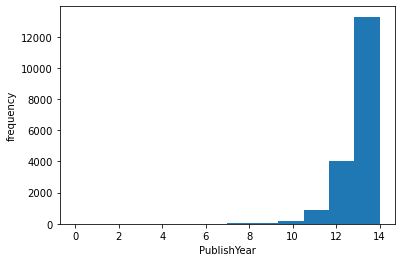

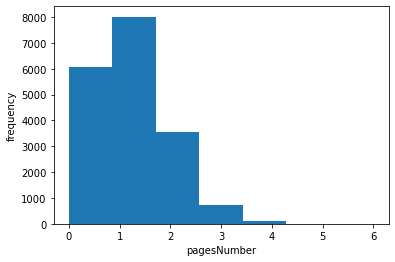

In [77]:
# check distribution of PublishYear and pagesNumber
for feature in ['PublishYear', 'pagesNumber']: 
    plt.hist(X_train[feature], bins = X_train[feature].nunique())
    plt.xlabel(feature)
    plt.ylabel('frequency')
    plt.show()

In [83]:
gaussian_features = ['PublishYear', 'pagesNumber']
X_train_gaussian = X_train[gaussian_features]
X_val_gaussian = X_val[gaussian_features]

Evaluate on training set:

GaussianNB prediction took 0.31049299240112305 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.822023           0.125000       0.698808
1                 0.0           0.820972           0.000000       0.695558
2                 0.0           0.823529           0.130435       0.700975
3                 0.0           0.823077           0.160000       0.699892
4                 0.0           0.821953           0.000000       0.697725
5                 0.0           0.823229           0.046512       0.699892
6                 0.0           0.823529           0.130435       0.700975
7                 0.0           0.825336           0.212766       0.704225
8                 0.0           0.821497           0.085106       0.697725
9                 0.0           0.825559           0.177778       0.704225
10                0.0           0.825782           0.097561       0.703905
11                

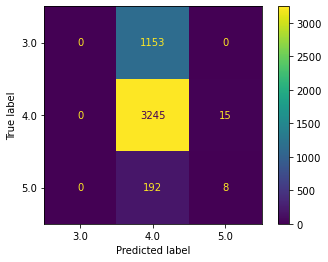

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.35      0.04      0.07       200

    accuracy                           0.71      4613
   macro avg       0.35      0.35      0.30      4613
weighted avg       0.51      0.71      0.59      4613



In [171]:
gnb = GaussianNB()
gaussian_pred = validate_and_test(gnb, X_train_gaussian, y_train, X_val_gaussian, y_val)

### Categorical NB for Authors and Publisher

In [273]:
from sklearn.preprocessing import OrdinalEncoder

categorical_features = ['Authors', 'Publisher']
X_categorical = original_train_df[categorical_features]
for feature in categorical_features: 
    X_categorical[feature] = original_train_df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
enc = OrdinalEncoder()
X_categorical = enc.fit_transform(X_categorical)
#X_categorical[categorical_features] = X_categorical[categorical_features].apply(lambda feature: pd.factorize(feature)[0])


In [175]:
X_train_categorical, X_val_categorical, _, _ = train_test_split(X_categorical, y_full_train, train_size=0.8, random_state=30027)

In [310]:
# Tuning for alpha smoothing
cnb = CategoricalNB(min_categories = [enc.categories_[0].size, enc.categories_[1].size])
param_grid = {'alpha': [i/10 for i in range(1, 15, 1)]}
tune_hyperparameter(cnb, param_grid, X_train_categorical, y_train.astype(int))

# larger alpha -> overestimate the likelihood
# could be because there is more samples with label4 ratings, and the missing values are randomly 
# distributed across the dataset, hence more samples with label4 rating with missing values
# -> likelihood of P(x|c=4) overestimated -> more samples predicted to have label=4

Fitting 20 folds for each of 14 candidates, totalling 280 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .....................................

[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.0s
[CV] END ...................

[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ...................

,params,mean_test_3_f1-score,rank_test_3_f1-score,mean_test_4_f1-score,rank_test_4_f1-score,mean_test_5_f1-score,rank_test_5_f1-score,mean_test_accuracy,rank_test_accuracy
0,{'alpha': 0.1},0.446241,1,0.726771,14,0.244678,5,0.614902,14
1,{'alpha': 0.2},0.420271,2,0.761333,13,0.249093,4,0.645905,13
2,{'alpha': 0.3},0.410157,3,0.772680,12,0.298151,1,0.665363,12
3,{'alpha': 0.4},0.402310,4,0.779877,11,0.269942,2,0.671975,11
4,{'alpha': 0.5},0.389375,5,0.784260,10,0.254377,3,0.674902,10
5,{'alpha': 0.6},0.380088,6,0.788301,9,0.216106,6,0.677829,7
6,{'alpha': 0.7},0.375190,7,0.789442,8,0.196507,7,0.678263,6
7,{'alpha': 0.8},0.365809,8,0.790416,6,0.144934,8,0.677396,8
8,{'alpha': 0.9},0.359789,9,0.790224,7,0.142664,9,0.676474,9
9,{'alpha': 1.0},0.312930,10,0.824543,2,0.137128,10,0.717831,1


Evaluate on training set:

CategoricalNB prediction took 0.29102301597595215 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.249201           0.816958           0.127660       0.703142
1            0.298137           0.822417           0.093023       0.713976
2            0.326019           0.832659           0.177778       0.729144
3            0.333333           0.824728           0.090909       0.719393
4            0.302115           0.819048           0.133333       0.709642
5            0.283912           0.824798           0.177778       0.716143
6            0.393750           0.844444           0.048780       0.748646
7            0.280255           0.825269           0.136364       0.716143
8            0.338558           0.832659           0.133333       0.730228
9            0.357955           0.822314           0.095238       0.717226
10           0.377581           0.833105           0.139535       0.733189
11           0.

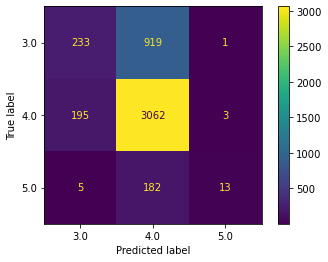

              precision    recall  f1-score   support

         3.0       0.54      0.20      0.29      1153
         4.0       0.74      0.94      0.83      3260
         5.0       0.76      0.07      0.12       200

    accuracy                           0.72      4613
   macro avg       0.68      0.40      0.41      4613
weighted avg       0.69      0.72      0.66      4613



In [313]:
cnb = CategoricalNB(min_categories = [enc.categories_[0].size, enc.categories_[1].size])
y_pred = validate_and_test(cnb, X_train_categorical, y_train, X_val_categorical, y_val)


### Multinomial NB for Name and Description

In [154]:
X_text = pd.concat([train_df_name, train_df_desc], axis=1)
X_train_multinomial, X_val_multinomial, _, _ = train_test_split(X_text, y_full_train, train_size=0.8, random_state=30027)


Evaluate on training set:

MultinomialNB prediction took 1.4765942096710205 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.093385           0.824595           0.045455       0.704225
1            0.072289           0.826255           0.000000       0.705309
2            0.047431           0.817594           0.042553       0.692308
3            0.101562           0.825890           0.088889       0.707476
4            0.064257           0.824968           0.000000       0.703142
5            0.040486           0.822394           0.088889       0.699892
6            0.070866           0.825806           0.095238       0.705309
7            0.099617           0.823912           0.130435       0.704225
8            0.123552           0.827273           0.042553       0.708559
9            0.093385           0.825130           0.088889       0.705309
10           0.047809           0.821935           0.139535       0.700651
11           0.0

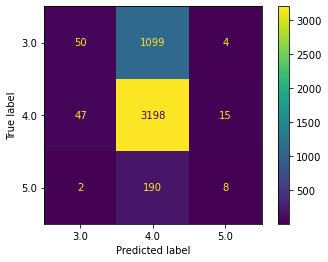

              precision    recall  f1-score   support

         3.0       0.51      0.04      0.08      1153
         4.0       0.71      0.98      0.83      3260
         5.0       0.30      0.04      0.07       200

    accuracy                           0.71      4613
   macro avg       0.50      0.35      0.33      4613
weighted avg       0.64      0.71      0.61      4613



In [158]:
# better than complementNB and gaussianNB
mnb = MultinomialNB()
multinomial_pred = validate_and_test(mnb, X_train_multinomial, y_train, X_val_multinomial, y_val)

### Combined Classifier by voting

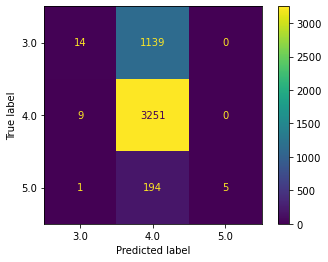

              precision    recall  f1-score   support

         3.0       0.58      0.01      0.02      1153
         4.0       0.71      1.00      0.83      3260
         5.0       1.00      0.03      0.05       200

    accuracy                           0.71      4613
   macro avg       0.76      0.34      0.30      4613
weighted avg       0.69      0.71      0.59      4613



In [177]:
# combine all nbs by voting
def most_common(predictions):
    return max(set(predictions), key=predictions.count)

nb_pred = []
for predictions in zip(gaussian_pred, categorical_pred, multinomial_pred): 
    nb_pred.append(most_common(predictions))

cm = confusion_matrix(y_val, nb_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
display.plot()
plt.show()
print(classification_report(y_val, nb_pred, zero_division=0))

### Categorical NB for final prediction

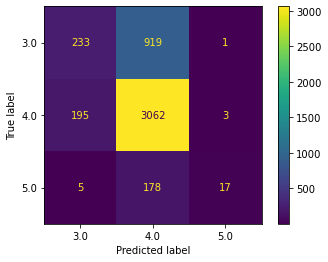

              precision    recall  f1-score   support

         3.0       0.54      0.20      0.29      1153
         4.0       0.74      0.94      0.83      3260
         5.0       0.81      0.09      0.15       200

    accuracy                           0.72      4613
   macro avg       0.69      0.41      0.42      4613
weighted avg       0.69      0.72      0.66      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [178]:
# use a categorical nb to predict the final rating
# training dataframe
gnb.fit(X_train_gaussian, y_train)
gaussian_pred_training = gnb.predict(X_train_gaussian)
cnb.fit(X_train_categorical, y_train)
cetegorical_pred_training = cnb.predict(X_train_categorical)
mnb.fit(X_train_multinomial, y_train)
multinomial_pred_training = mnb.predict(X_train_multinomial)

X_predictions_training = pd.DataFrame({'GaussianNB_Year_Pages' : gaussian_pred_training,
                                'CategoricalNB_Author_Publisher' : cetegorical_pred_training,
                                'MultinomialNB_Name_Desc' : multinomial_pred_training})

# validation dataframe
X_predictions_val = pd.DataFrame({'GaussianNB_Year_Pages' : gaussian_pred,
                                'CategoricalNB_Author_Publisher' : categorical_pred,
                                'MultinomialNB_Name_Desc' : multinomial_pred})

final_nb = CategoricalNB()
final_nb.fit(X_predictions_training, y_train)
evaluate(final_nb, X_predictions_val, y_val, print_confusion_matrix=True, print_classification_report=True)

### Generate Model

In [334]:
def combinedNB_fit_validate(X_numeric_train, X_string_train, X_string_test, X_text_train, y):
    '''
    fit a combined NB model and perform cross validation
    Input: 
        X_numeric_train = df containing preprocessed PublishYear and PagesNumber
        X_string_train = df containing un-preprocessed Author and Publisher in training set
        X_string_test = df containing un-preprocessed Author and Publisher in testing set (needed to fit OrdinalEncoder)
        X_text_train = df containing preprocessed Name and Description
        y = y_train
    returns all the fitted models needed for predicting test set, and the fitted OrdinalEncoder
    '''
    # fit a gaussianNB for PublishYear and PagesNumber
    gnb = GaussianNB()
    gnb.fit(X_numeric_train, y)
    gaussian_pred = gnb.predict(X_numeric_train)
    
    # fit a categoricalNB for Author and Publisher
    categorical_features = ['Authors', 'Publisher']
    # preprocess and encode the string features
    for feature in categorical_features: 
        X_string_train[feature] = X_string_train[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
        X_string_test[feature] = X_string_test[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    X_string_full = pd.concat([X_string_train, X_string_test])
    enc = OrdinalEncoder()
    enc.fit(X_string_full)
    X_string_train = enc.transform(X_string_train)
    #fit model
    cnb = CategoricalNB(alpha = 1, min_categories = [enc.categories_[0].size, enc.categories_[1].size])
    cnb.fit(X_string_train, y)
    categorical_pred = cnb.predict(X_string_train)
    
    # fit a multinomialNB for Name and Description
    mnb = MultinomialNB()
    mnb.fit(X_text_train, y)
    multinomial_pred = mnb.predict(X_text_train)
    
    # fit a categorical nb to combine the predictions
    final_nb = CategoricalNB()
    X_predictions = pd.DataFrame({'GaussianNB_Year_Pages' : gaussian_pred,
                                'CategoricalNB_Author_Publisher' : categorical_pred,
                                'MultinomialNB_Name_Desc' : multinomial_pred})
    final_nb.fit(X_predictions, y)
    print(validate(final_nb, X_predictions, y))
    return gnb, cnb, mnb, final_nb, enc


def combinedNB_predict(X_numeric_test, X_string_test, X_text_test, y, gnb, cnb, mnb, final_nb, enc): 
    gaussian_pred = gnb.predict(X_numeric_test)
    
    # preprocess strings
    categorical_features = ['Authors', 'Publisher']
    # preprocess
    for feature in categorical_features: 
        X_string_test[feature] = X_string_test[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    X_string_test = enc.transform(X_string_test)
    categorical_pred = cnb.predict(X_string_test)
    
    multinomial_pred = mnb.predict(X_text_test)
    X_predictions = pd.DataFrame({'GaussianNB_Year_Pages' : gaussian_pred,
                                'CategoricalNB_Author_Publisher' : categorical_pred,
                                'MultinomialNB_Name_Desc' : multinomial_pred})
    
    prediction = evaluate(final_nb, X_predictions, y)
    return prediction
    
    
def combinedNB_fit_validate_predict(X_numeric_train, X_string_train, X_text_train, y_train, 
                          X_numeric_test, X_string_test, X_text_test, y_test): 
    print("Evaluate on training set:\n")
    gnb, cnb, mnb, final_nb, encoder = combinedNB_fit_validate(X_numeric_train, X_string_train, X_string_test, X_text_train, y_train)
    print("\n\nEvaluate on validation set:\n")
    y_pred = combinedNB_predict(X_numeric_test, X_string_test, X_text_test, y_test, gnb, cnb, mnb, final_nb, encoder)
    return y_pred
    
    
    

In [336]:
X_string_train, X_string_val, _, _ = train_test_split(original_train_df[['Authors', 'Publisher']], y_full_train, train_size=0.8, random_state=30027)
X_text = pd.concat([train_df_name, train_df_desc], axis=1)
X_text_train, X_text_val, _, _ = train_test_split(X_text, y_full_train, train_size=0.8, random_state=30027)

Evaluate on training set:

CategoricalNB prediction took 0.25360107421875 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.710526           0.907670           0.586207       0.856988
1            0.746032           0.910626           0.297872       0.861322
2            0.725333           0.910374           0.518519       0.861322
3            0.746114           0.913229           0.518519       0.866739
4            0.762887           0.917496           0.461538       0.872156
5            0.728232           0.910891           0.490566       0.861322
6            0.764858           0.919458           0.571429       0.876490
7            0.733333           0.910650           0.596491       0.863489
8            0.778351           0.922198           0.596491       0.881907
9            0.741117           0.912607           0.571429       0.865655
10           0.732468           0.912456           0.555556       0.864425
11           0.715

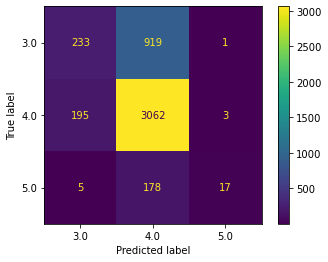

              precision    recall  f1-score   support

         3.0       0.54      0.20      0.29      1153
         4.0       0.74      0.94      0.83      3260
         5.0       0.81      0.09      0.15       200

    accuracy                           0.72      4613
   macro avg       0.69      0.41      0.42      4613
weighted avg       0.69      0.72      0.66      4613



In [337]:
y_pred = combinedNB_fit_validate_predict(X_train[['PublishYear', 'pagesNumber']], X_string_train, X_text_train, y_train, 
                               X_val[['PublishYear', 'pagesNumber']], X_string_val, X_text_val, y_val)

## the model has overfitted (?) the training set, since we have fitted both the base model and the 
# combined model to the training set
# is it overfitted tho? coz although training scores are high, but the validation scores are not bad...


## SVM

### Linear

In [ ]:
from sklearn import svm

In [ ]:
linearSVM = svm.LinearSVC(random_state=30027, C=10) # set C?
linearSVM.fit(X_train, y_train)
validate_and_test(linearSVM, X_train, y_train, X_val, y_val)

In [ ]:
# Linear SVM using Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# learning_rate='optimal' predicts most 4s as 3s
# validation accuracy stops increasing for eta0 < 0.0000001
svm_sgd = SGDClassifier(learning_rate='adaptive', eta0 = 0.0000001)  # default: loss='hinge' -> gives a linear SVM
validate_and_test(svm_sgd, X_train, y_train, X_val, y_val)

### Kernel SVM

In [ ]:
# tune hyperparameter C
RBF_svm = svm.SVC(kernel='rbf', gamma=0.9)
param_grid = {'C': range(1, 10)}
grid_search_result = tune_hyperparameter(RBF_svm, param_grid, X_train, y_train)

In [ ]:
grid_search_result

In [ ]:
# Try kernel SVM
RBF_svm = svm.SVC(kernel='rbf', gamma=0.9, C=10)
validate_and_test(RBF_svm, X_train, y_train, X_val, y_val)

## kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# tune hyperparameters p and K
knn = KNeighborsClassifier(weights = 'distance')
param_grid = {'p': [1,2], 'n_neighbors': range(1,11)}
grid_search_result = tune_hyperparameter(knn, param_grid, X_train, y_train)

In [ ]:
grid_search_result
# p=2 (euclidean distance) is generally better
# larger k models prefers label 4.0 and hence results in higher accuracy due to data imbalance

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
validate_and_test(knn, X_train, y_train, X_val, y_val)

## Decision Tree

In [254]:
from sklearn.tree import DecisionTreeClassifier

In [266]:
# tune hyperparameter max_depth
dtc = DecisionTreeClassifier(random_state = 30027)
param_grid = {'max_depth': range(2,21)}
grid_search_result = tune_hyperparameter(dtc, param_grid, X_train, y_train)

Fitting 20 folds for each of 19 candidates, totalling 380 fits
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END .....................................

[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ...................

[CV] END .......................................max_depth=12; total time=   0.0s
[CV] END .......................................max_depth=12; total time=   0.0s
[CV] END .......................................max_depth=12; total time=   0.0s
[CV] END .......................................max_depth=12; total time=   0.0s
[CV] END .......................................max_depth=12; total time=   0.0s
[CV] END .......................................max_depth=12; total time=   0.0s
[CV] END .......................................max_depth=12; total time=   0.0s
[CV] END .......................................max_depth=12; total time=   0.0s
[CV] END .......................................max_depth=13; total time=   0.0s
[CV] END .......................................max_depth=13; total time=   0.0s
[CV] END .......................................max_depth=13; total time=   0.0s
[CV] END .......................................max_depth=13; total time=   0.0s
[CV] END ...................

[CV] END .......................................max_depth=17; total time=   0.0s
[CV] END .......................................max_depth=17; total time=   0.0s
[CV] END .......................................max_depth=17; total time=   0.0s
[CV] END .......................................max_depth=17; total time=   0.0s
[CV] END .......................................max_depth=17; total time=   0.0s
[CV] END .......................................max_depth=18; total time=   0.0s
[CV] END .......................................max_depth=18; total time=   0.0s
[CV] END .......................................max_depth=18; total time=   0.0s
[CV] END .......................................max_depth=18; total time=   0.0s
[CV] END .......................................max_depth=18; total time=   0.0s
[CV] END .......................................max_depth=18; total time=   0.0s
[CV] END .......................................max_depth=18; total time=   0.0s
[CV] END ...................

In [267]:
grid_search_result
# smaller depth converge towards 0R and prefers 4.0 label

,params,mean_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,rank_test_accuracy
0,{'max_depth': 2},0.000000,15,0.825003,19,0.021780,19,0.702277,19
1,{'max_depth': 3},0.000000,15,0.825480,17,0.072319,18,0.703307,18
2,{'max_depth': 4},0.000000,15,0.825469,18,0.074532,17,0.703307,17
3,{'max_depth': 5},0.000000,15,0.825612,16,0.083509,16,0.703578,16
4,{'max_depth': 6},0.000000,15,0.825729,14,0.111488,15,0.703957,15
5,{'max_depth': 7},0.000424,14,0.825723,15,0.117725,14,0.704012,14
6,{'max_depth': 8},0.000847,13,0.825870,1,0.130770,13,0.704337,3
7,{'max_depth': 9},0.001269,1,0.825799,13,0.134432,3,0.704283,5
8,{'max_depth': 10},0.001269,1,0.825862,2,0.136703,1,0.704391,1
9,{'max_depth': 11},0.001269,1,0.825836,4,0.134432,3,0.704337,4


Evaluate on training set:

DecisionTreeClassifier prediction took 0.4901292324066162 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.000000           0.825032           0.136364       0.703142
1            0.000000           0.824204           0.000000       0.700975
2            0.000000           0.826837           0.222222       0.706392
3            0.000000           0.826087           0.217391       0.705309
4            0.000000           0.823229           0.046512       0.699892
5            0.000000           0.823755           0.090909       0.700975
6            0.000000           0.823755           0.093023       0.700975
7            0.000000           0.826309           0.181818       0.705309
8            0.008439           0.825032           0.093023       0.703142
9            0.000000           0.825255           0.095238       0.703142
10           0.000000           0.825782           0.097561       0.703905
11     

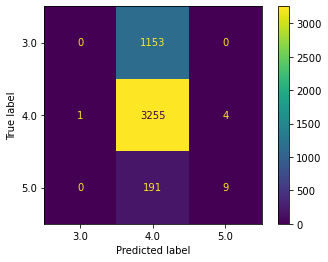

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.69      0.04      0.08       200

    accuracy                           0.71      4613
   macro avg       0.47      0.35      0.30      4613
weighted avg       0.53      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [263]:
dtc = DecisionTreeClassifier(max_depth=20, random_state = 30027)
validate_and_test(dtc, X_train, y_train, X_val, y_val)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# using full feature set
logr = LogisticRegression()
validate_and_test(logr, X_train, y_train, X_val, y_val)

Evaluate on training set:



In [ ]:
# Feature selection
selector = SelectKBest(k=100)
selector.fit(X_train, y_train)
X_train_reduced = selector.transform(X_train)
X_val_reduced = selector.transform(X_val)
print(X_train_reduced.shape)
print(X_val_reduced.shape)

In [ ]:
# using reduced feature set
validate_and_test(logr, X_train_reduced, y_train, X_val_reduced, y_val)



In [ ]:
# Logistic regression using Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# learning_rate='optimal' -> validation accuracy = 0.535
# probabilistic -> different accuracy each time
# eta0=0.0000001 -> low variance, capped at 0.698
# eta0=0.001 -> high variance, occasionally reached 0.7
logr_sgd = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.0000001)
validate_and_test(logr_sgd, X_train, y_train, X_val, y_val)

## Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adab = AdaBoostClassifier(n_estimators=100, random_state=30027)
validate_and_test(adab, X_train, y_train, X_val, y_val)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=30027)
validate_and_test(rf, X_train, y_train, X_val, y_val)

## Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier

classifiers = [('linearSVM', linearSVM), ('svm_sgd', svm_sgd), ('RBF_svm', RBF_svm), ('knn', knn), ('dtc', dtc)]#, ('logr', logr)]
sc = StackingClassifier(classifiers, verbose = 1)
validate_and_test(sc, X_train, y_train, X_val, y_val)

In [ ]:
evaluate(stacking_clf, X_val, y_val, print_confusion_matrix=True, print_classification_report=True)

## Baseline - 0R & 1R

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.dummy import DummyClassifier

In [ ]:
# build and test 0R and 1R model
zero_r = DummyClassifier(strategy='most_frequent')
one_r = DecisionTreeClassifier(max_depth=1)
baselines = [zero_r, one_r]

for baseline in baselines: 
    validate_and_test(baseline, X_train, y_train, X_val, y_val, print_full_cv_results=False)
    print("\n*****************************\n")